# 計算坐標在西南官話相關詞彙中的出現次數

In [1]:
#提取文件夹及子文件夹的xlsx文件路径
import os

def get_xlsx_paths(directory):
    xlsx_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.xlsx'):
                xlsx_paths.append(os.path.join(root, file))
    return xlsx_paths

### 版本1：忽略省志，不按朝代篩選

In [ ]:
import pandas as pd

coordinate_count = {} # 儲存坐標及在幾個文件中出現的字典

for file in xlsx_files:
    print(f'正在處理{file}')
    df = pd.read_excel(file, engine='openpyxl')
    df['地域'] = df['地域'].astype(str) # 确保地域列是字符串类型
    df = df[~df['地域'].str.contains('1')] # 地域列中有“1”的是省志，将其删除
    
    unique_coordinates = set(df.dropna(subset=['X', 'Y'])[['X', 'Y']].itertuples(index=False, name=None))
    
    for coordinate in unique_coordinates:
        if coordinate in coordinate_count:
            coordinate_count[coordinate] += 1
        else:
            coordinate_count[coordinate] = 1

result_df = pd.DataFrame(list(coordinate_count.items()), columns=['Coordinate', 'Count'])
result_df[['X', 'Y']] = pd.DataFrame(result_df['Coordinate'].tolist(), index=result_df.index)
result_df = result_df.drop(columns=['Coordinate'])

output_file_path = r"F:\data\新建文件夹\坐標次數.xlsx"
result_df.to_excel(output_file_path, index=False)

### 版本2：忽略省志，並篩選指定朝代的方志

In [ ]:
import pandas as pd

coordinate_count = {} # 儲存坐標及在幾個文件中出現的字典

dynasty = '明'
for file in xlsx_files:
    print(f'正在處理{file}')
    df = pd.read_excel(file, engine='openpyxl')
    df['地域'] = df['地域'].astype(str) # 确保地域列是字符串类型
    df = df[~df['地域'].str.contains('1')] # 地域列中有“1”的是省志，将其删除
    df = df.dropna(subset=['時間段'])
    df = df[df['時間段'].str.contains(dynasty)]
    
    unique_coordinates = set(df.dropna(subset=['X', 'Y'])[['X', 'Y']].itertuples(index=False, name=None))
    
    for coordinate in unique_coordinates:
        if coordinate in coordinate_count:
            coordinate_count[coordinate] += 1
        else:
            coordinate_count[coordinate] = 1

result_df = pd.DataFrame(list(coordinate_count.items()), columns=['Coordinate', 'Count'])
result_df[['X', 'Y']] = pd.DataFrame(result_df['Coordinate'].tolist(), index=result_df.index)
result_df = result_df.drop(columns=['Coordinate'])

output_file_path = f"F:/data/新建文件夹/{dynasty}-坐標次數.csv"
result_df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

# 找出文件夾中在xlsx文件中共現的“地域”內容，併統計相關數據


xlsx文件是利用`3-語料自動收集與輔助篩選.ipynb`得出的詞彙語料

In [61]:
# 最小索引年作爲詞彙出現年份代表，計算並保留地域平均索引年
import os
import pandas as pd
from itertools import combinations
import numpy as np

def analyze_region_cooccurrence(folder_path, process_function=None, process_function_name=None):
    # 獲取所有xlsx文件
    xlsx_files = get_xlsx_paths(folder_path)
    # 初始化字典來存儲每個地域的信息
    region_data = {}

    # 遍歷所有文件
    for file in xlsx_files:
        print(file)
        df = pd.read_excel(file)
        # 刪除"地域"列是空白的行
        df = df[df['地域'].notna()]
        # 去除路徑和後綴的文件名
        file_name = os.path.splitext(os.path.basename(file))[0]
        
        # 如果有處理函數，則應用它
        if process_function:
            df = process_function(df)
        
        # 對每個文件中的每個地域進行處理
        for region, group in df.groupby('地域'):
            if region not in region_data:
                region_data[region] = {}
            
            # 將文件名（即詞彙）作爲鍵，最小索引年爲值
            region_data[region][file_name] = min(group['索引年'].tolist())

    # 計算共現數據
    result = []
    for region1, region2 in combinations(region_data.keys(), 2):  # 生成無序且不重複的組合
        common_files = set(region_data[region1].keys()) & set(region_data[region2].keys())
        if common_files:
            # 計算平均索引年
            index_years1 = [region_data[region1][file] for file in common_files]
            index_years2 = [region_data[region2][file] for file in common_files]
            avg_index_year1 = round(sum(index_years1) / len(index_years1)) if index_years1 else 0
            avg_index_year2 = round(sum(index_years2) / len(index_years2)) if index_years2 else 0
            result.append({
                '地域1': region1,
                '地域2': region2,
                '共現次數': len(common_files),
                '共現詞彙': ', '.join(common_files),
                '地域1平均索引年': avg_index_year1,
                '地域2平均索引年': avg_index_year2,
                '地域1索引年列表': index_years1,
                '地域2索引年列表': index_years2
            })

    # 創建結果DataFrame並導出爲CSV
    result_df = pd.DataFrame(result)
    output_file = os.path.join(folder_path, f'{process_function_name}-地域共現統計.csv')
    result_df.to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"統計結果已保存至：{output_file}")

In [ ]:
# 處理省的函數
def process_province(df):
    # "地域"列的內容提取空格前的第一個內容
    df['地域'] = df['地域'].str.split().str[0]
    return df

folder_path = r'F:\data\新建文件夹'
analyze_region_cooccurrence(folder_path, process_province, '省')


In [ ]:
# 處理市的函數
def process_city(df):
    # "地域"列中提取空格分隔的前兩個內容，將它們合併
    df['地域'] = df['地域'].apply(lambda x: ' '.join(x.split()[:2]))
    #刪除含有“1”的“地域”列
    df = df[~df['地域'].str.contains('1', na=False)]
    return df

folder_path = r'F:\data\新建文件夹'
analyze_region_cooccurrence(folder_path, process_city, '市')


In [ ]:
# 處理縣的函數
def process_county(df):
    #刪除含有“1”或“2”的“地域”列
    df = df[~df['地域'].str.contains('1', na=False) & ~df['地域'].str.contains('2', na=False)]
    return df

folder_path = r'F:\data\新建文件夹'
analyze_region_cooccurrence(folder_path, process_county, '縣')

In [ ]:
# 處理市和縣的函數
def process_city_county(df):
    #刪除含有“1”的“地域”列,以便排除省志
    df = df[~df['地域'].str.contains('1', na=False)]
    return df

folder_path = r'F:\data\新建文件夹'
analyze_region_cooccurrence(folder_path, process_city_county, '市縣')

# 創建適合用arcmap繪制OD圖的csv文件

In [2]:
import pandas as pd

In [ ]:
file_path = r'F:\data\新建文件夹\市縣-地域共現統計.csv'
df = pd.read_csv(file_path)
#删除“地域”列的“ 1”或“ 2”字符串，以便後續能夠匹配“地域及坐標-平均.xlsx”文件的“地域”列格式
df['地域1'] = df['地域1'].str.replace(r'(?: 1| 2)', '', regex=True)
df['地域2'] = df['地域2'].str.replace(r'(?: 1| 2)', '', regex=True)
df.head()
# 讀取地域坐標數據
coord_df = pd.read_excel(r'E:\坚果云同步文件\论文内容\博士階段論文\畢業論文\論文數據\地域及坐標-平均.xlsx')

# 最小共現次數
min_co_count = 2

# 過濾小於最小共現次數的行
df = df[df['共現次數'] >= min_co_count]

# 創建新的DataFrame來存儲OD數據
od_df = pd.DataFrame(columns=['O_Name', 'D_Name', 'O_X', 'O_Y', 'D_X', 'D_Y', 'Co_Count'])

for _, row in df.iterrows():
    地域1 = row['地域1']
    地域2 = row['地域2']
    共現次數 = row['共現次數']
    地域1平均索引年 = row['地域1平均索引年']
    地域2平均索引年 = row['地域2平均索引年']
    地域1索引年列表 = row['地域1索引年列表']
    地域2索引年列表 = row['地域2索引年列表']
    
    # 獲取坐標
    coord1 = coord_df[coord_df['地域'] == 地域1].iloc[0]
    coord2 = coord_df[coord_df['地域'] == 地域2].iloc[0]
    
    # 根據平均索引年決定起點和終點
    if 地域1平均索引年 < 地域2平均索引年:
        new_row = pd.DataFrame({
            'O_Name': [地域1], 'D_Name': [地域2],
            'O_X': [coord1['X']], 'O_Y': [coord1['Y']],
            'D_X': [coord2['X']], 'D_Y': [coord2['Y']],
            'Co_Count': [共現次數],
            'O_Years': [地域1索引年列表], 'D_Years': [地域2索引年列表]
        })
        od_df = pd.concat([od_df, new_row], ignore_index=True)
    elif 地域1平均索引年 > 地域2平均索引年:
        new_row = pd.DataFrame({
            'O_Name': [地域2], 'D_Name': [地域1],
            'O_X': [coord2['X']], 'O_Y': [coord2['Y']],
            'D_X': [coord1['X']], 'D_Y': [coord1['Y']],
            'Co_Count': [共現次數],
            'O_Years': [地域2索引年列表], 'D_Years': [地域1索引年列表]
        })
        od_df = pd.concat([od_df, new_row], ignore_index=True)
    else:
        # 如果平均索引年相同，則互爲起點和終點
        new_row = pd.DataFrame({
            'O_Name': [地域1], 'D_Name': [地域2],
            'O_X': [coord1['X']], 'O_Y': [coord1['Y']],
            'D_X': [coord2['X']], 'D_Y': [coord2['Y']],
            'Co_Count': [共現次數],
            'O_Years': [地域1索引年列表], 'D_Years': [地域2索引年列表]
        })
        od_df = pd.concat([od_df, new_row], ignore_index=True)
        
        new_row = pd.DataFrame({
            'O_Name': [地域2], 'D_Name': [地域1],
            'O_X': [coord2['X']], 'O_Y': [coord2['Y']],
            'D_X': [coord1['X']], 'D_Y': [coord1['Y']],
            'Co_Count': [共現次數],
            'O_Years': [地域2索引年列表], 'D_Years': [地域1索引年列表]
        })
        od_df = pd.concat([od_df, new_row], ignore_index=True)

# 保存結果到CSV文件
output_path = r'F:\data\新建文件夹\OD_data_for_arcmap.csv'
od_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"OD數據已保存到：{output_path}")

# 篩選具有指定字符串的df行

In [16]:
# 篩選指定字符串列表的行，去除省內關係，進一步忽略流入地或流出地是省內者
import pandas as pd

# 文件路徑
path = r'F:\data\新建文件夹\OD_data_for_arcmap.csv'
# 讀取CSV文件
df = pd.read_csv(path)

# 要篩選的指定字符串列表
file_path = r'E:\坚果云同步文件\论文内容\博士階段論文\畢業論文\論文數據\愛如生方志庫-湖南西南官話區.xlsx'
sheet_name = '懷玉小片縣志'
df_1 = pd.read_excel(file_path, sheet_name=sheet_name)
filter_strings = df_1['地域'].unique().tolist()
province = '湖南' # 要去除的省內關繫
O_or_D = 'D' # 要關註的是流入地/流出地，後續會刪除流入地/流出地是province的內容
field = f'{O_or_D}_Name'

# 創建一個佈爾索引，用於篩選包含指定字符串的行
filter_condition = df['O_Name'].str.contains('|'.join(filter_strings)) | df['D_Name'].str.contains('|'.join(filter_strings))

# 篩選數據
filtered_df = df[filter_condition]

# 去除省內關繫
filtered_df = filtered_df[~((filtered_df['O_Name'].str.contains(province)) & (filtered_df['D_Name'].str.contains(province)))]
filtered_df = filtered_df[~(filtered_df[field].str.contains(province))]

# 保存篩選後的數據到新的CSV文件
output_folder = r'F:\data\新建文件夹'
filename = f'{O_or_D}_{sheet_name[0:4]}.csv'
output_path = os.path.join(output_folder, filename)
filtered_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"筛选后的数据已保存到：{output_path}")

筛选后的数据已保存到：F:\data\新建文件夹\D_懷玉小片.csv


# 將經過篩選的OD數據進一步篩選指定區域，並繪製索引年的箱線圖

In [7]:
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import numpy as np

# 設置中文字體
font_path = r'C:\Windows\Fonts\SimHei.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [8]:
def get_index_years(file_path, O_or_D, region):
    '''
    region是需要關注的區域
    '''
    name_field = f'{O_or_D}_Name'
    df = pd.read_csv(file_path)
    df = df[df[name_field].str.contains(region)]
    # 读取成Python列表格式
    df['D_Years'] = df['D_Years'].apply(ast.literal_eval)
    merged_list = []
    for index, row in df.iterrows():
        merged_list.extend(row['D_Years']) # 被流入的地域方志年份才能體現影響
    return merged_list

### 版本1：詞彙流出小提琴圖

In [2]:
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import rainbow
from matplotlib.collections import PolyCollection
from matplotlib.font_manager import FontProperties

# 設置中文字體
font_path = r'C:\Windows\Fonts\SimHei.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

def get_index_years(file_path, O_or_D, region):
    name_field = f'{O_or_D}_Name'
    df = pd.read_csv(file_path)
    df = df[df[name_field].str.contains(region)]
    df['D_Years'] = df['D_Years'].apply(ast.literal_eval)
    merged_list = []
    for index, row in df.iterrows():
        merged_list.extend(row['D_Years'])
    return merged_list


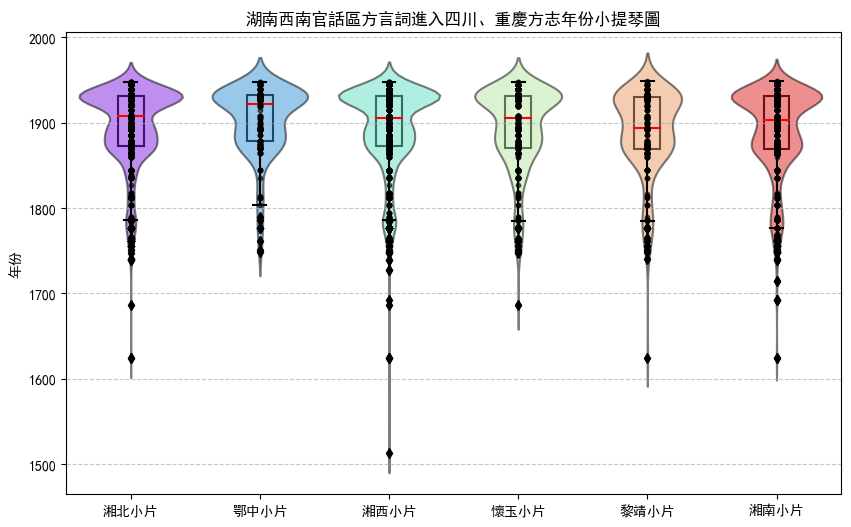

In [13]:
region = '四川|重慶'
O_or_D = 'D'

file_path_list = [f'F://data//新建文件夹//{O_or_D}_湘北小片.csv',
                  f'F://data//新建文件夹//{O_or_D}_鄂中小片.csv',
                  f'F://data//新建文件夹//{O_or_D}_湘西小片.csv',
                  f'F://data//新建文件夹//{O_or_D}_懷玉小片.csv',
                  f'F://data//新建文件夹//{O_or_D}_黎靖小片.csv',
                  f'F://data//新建文件夹//{O_or_D}_湘南小片.csv']

labels = []
nested_list = []
for file_path in file_path_list:
    file_name = os.path.basename(file_path)
    label = file_name[2:6]
    labels.append(label)
    
    merged_list = get_index_years(file_path, O_or_D, region)
    nested_list.append(merged_list)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# 使用seaborn繪制小提琴圖
sns.violinplot(data=nested_list, inner=None, ax=ax, palette=rainbow(np.linspace(0, 1, len(labels))))

# 在同一個圖上繪制箱線圖，設置顏色為黑色，沒有填充
sns.boxplot(
    data=nested_list,
    width=0.2,
    color='black',
    boxprops=dict(facecolor='none', edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='red'),
    ax=ax
)

# 設置橫坐標標簽
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

# 設置小提琴圖的中位數線顏色和寬度
for i, violin in enumerate(ax.collections):
    if isinstance(violin, PolyCollection):  # 确保我们只改变 violin 部分
        violin.set_edgecolor('black')
        violin.set_linewidth(1.5)
        violin.set_alpha(0.5)  # 设置透明度为 0.7

# 添加數據點
for i, dataset in enumerate(nested_list):
    # 計算每個數據集的中位數
    medians = [np.median(dataset)] * len(dataset)
    # 繪制散點
    ax.scatter([i] * len(dataset), dataset, color='black', alpha=0.6, s=10, zorder=10)

# 添加背景網格
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# 設置標題和y軸標簽
region = region.replace(' ','').replace('|','、')
if O_or_D == 'O':
    title = f'{region}方言詞進入湖南西南官話區方志年份小提琴圖'
elif O_or_D == 'D':
    title = f'湖南西南官話區方言詞進入{region}方志年份小提琴圖'

plt.title(title)
plt.ylabel('年份')


plt.show()

### 詞彙流入小提琴圖

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import rainbow
from matplotlib.collections import PolyCollection
from matplotlib.font_manager import FontProperties

# 設置中文字體
font_path = r'C:\Windows\Fonts\SimHei.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [3]:
def get_index_years(file_path, O_or_D, region):
    name_field = f'{O_or_D}_Name'
    df = pd.read_csv(file_path)
    df = df[df[name_field].str.contains(region)]
    df['D_Years'] = df['D_Years'].apply(ast.literal_eval)
    merged_list = []
    for index, row in df.iterrows():
        merged_list.extend(row['D_Years'])
    return merged_list

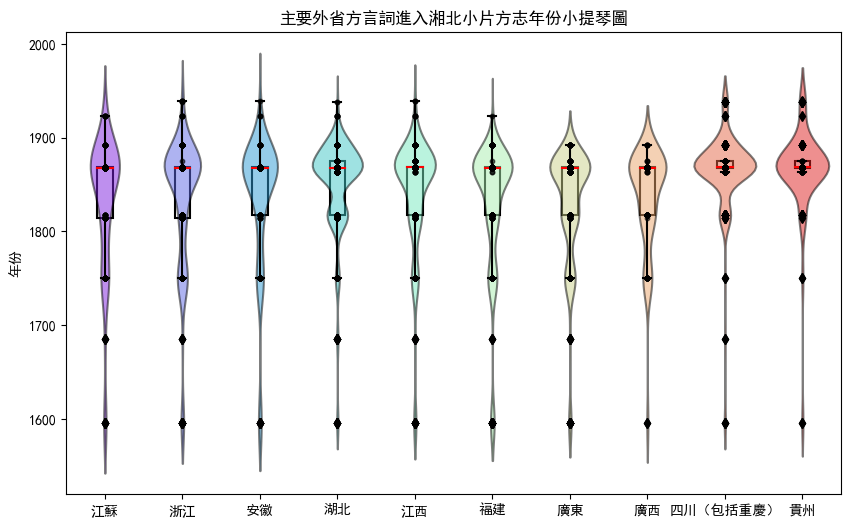

In [10]:
regions = ['江蘇', '浙江', '安徽','湖北', '江西', '福建', '廣東','廣西','四川|重慶','貴州']
O_or_D = 'O'
xiao_pian = '湘北'

file_path = f'F://data//新建文件夹//{O_or_D}_{xiao_pian}小片.csv'

labels = []
nested_list = []

for region in regions:
    label = region.replace(' ', '')
    if '|' in region:
        label = region.replace('|', '（包括') + '）'
    labels.append(label)
    merged_list = get_index_years(file_path, O_or_D, region)
    nested_list.append(merged_list)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# 使用seaborn繪制小提琴圖
sns.violinplot(data=nested_list, inner=None, ax=ax, palette=rainbow(np.linspace(0, 1, len(labels))))

# 在同一個圖上繪制箱線圖，設置顏色為黑色，沒有填充
sns.boxplot(
    data=nested_list,
    width=0.2,
    color='black',
    boxprops=dict(facecolor='none', edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='red'),
    ax=ax
)

# 設置橫坐標標簽
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

# 設置小提琴圖的中位數線顏色和寬度
for i, violin in enumerate(ax.collections):
    if isinstance(violin, PolyCollection): 
        violin.set_edgecolor('black')
        violin.set_linewidth(1.5)
        violin.set_alpha(0.5)  # 設置透明度

# 添加數據點
for i, dataset in enumerate(nested_list):
    # 計算每個數據集的中位數
    medians = [np.median(dataset)] * len(dataset)
    # 繪制散點
    ax.scatter([i] * len(dataset), dataset, color='black', alpha=0.6, s=10, zorder=10)

# 设置y轴标签和标题
if O_or_D == 'O':
    title = f'主要外省方言詞進入{xiao_pian}小片方志年份小提琴圖'
elif O_or_D == 'D':
    title = f'{xiao_pian}小片方言詞進入主要外省地方志年份小提琴圖'

plt.title(title)
plt.ylabel('年份')


plt.show()